<h1 style="font-family: Arial, sans-serif; font-size: 40px; color: white; text-align: center; margin-top: 40px;">Project 1A - Genetic Algorithms for Feature
Selection using Python</h1>
    <h2 style="font-family: Arial, serif; font-size: 24px; color: white; text-align: center; margin-top: 20px;">By Nick Askari and Simen Peder Stang</h2>

In [98]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import LinReg
import pandas as pd

## Defining paramters for the SGA

In [99]:
pop_size = 150
chromosome_length = 90
generation_number = 1
crossover_rate = 0.9
mutation_rate = 0.1
num_parents = int(np.floor(pop_size/2))
g_max = 10
enable_constraint = (False, [5, 10])

data = pd.read_csv("dataset.txt", header=None)
regressor = LinReg.LinReg()

## Defining the Individual

In [100]:
class Individual:
    def __init__(self, genotype, age, use_dataset) -> None:
        self.genotype = genotype
        self.phenotype = int(genotype, 2)
        self.age = age
        self.sin_fitness = self.calculate_sin_fitness()
        self.rmse_fitness = self.calculate_rmse_fitness(use_dataset)
        self.children = []
    
    def add_children(self, child):
        self.children.append(child)

    def scaled_phenotype(self):
        genotype_length = len(self.genotype)
        scaling_factor = (2**7) / (2**genotype_length)
        scaled_value = self.phenotype * scaling_factor
        return scaled_value
    
    def calculate_sin_fitness(self):
        x = self.scaled_phenotype()

        # Handle if there is a constraint
        if enable_constraint[0]:
            distance = self.calculate_distance(x)
            fitness = np.sin(x) + 1 - distance
            if fitness < 0:
                return 0
            else:
                return fitness
        else:
            # Scaling by 1 to avoid negative values
            return np.sin(x) + 1
    
    def calculate_rmse_fitness(self, use_dataset):
        if use_dataset:
            y = np.array([int(bit) for bit in self.genotype])
            X = regressor.get_columns(data.values, y)

            # Return rmse based on whether feature selection is activated (related to task g))

            return regressor.get_fitness(X, data.values[:,-1])
        else:
            return 0

    def calculate_distance(self, x):
        lower_bound, upper_bound = enable_constraint[1][0], enable_constraint[1][1]
        if x < lower_bound:
            return lower_bound - x
        elif x > upper_bound:
            return x - upper_bound
        else:
            return 0

    def grow_older(self):
        self.age += 1
    
    def __repr__(self):
        return f"Individual(genotype={self.genotype}, phenotype={self.phenotype}, sin_fitness={self.sin_fitness}, age={self.age})"
    
    def __hash__(self):
        return hash((self.genotype, self.phenotype))

## Sin Synthetic Problem

*a) Implement a function to generate an initial population for your genetic
algorithm.*

We are choosing to initialize the population, according to the size parameters. The actual genotypes (0's and 1's) will be generated randomly.

In [101]:
def init_population(use_dataset):
    population = []
    
    for _ in range(pop_size):
        new_genotype = ""
        for _ in range(chromosome_length):
            new_genotype += str(random.randint(0,1))

        new_individual = Individual(new_genotype, age=0, use_dataset=use_dataset)
        population.append(new_individual)
    return population

*b) Implement a parent selection function for your genetic algorithm. This function
should find the fittest individuals in the population, and select parents based
on this fitness.*

Here we are using the fitness function given by the sine function, as explained in the task. Moreover we are implementing a roulette-wheel approach as parent selection.

In [102]:
def roulette_wheel_parent_selection(population, use_dataset):    
    # Probability of choosing each individual based on the roulette wheel approach
    if use_dataset:
        # Minimizing
        total_fitness = sum(1.0 / individual.rmse_fitness for individual in population)
        probabilities = [(1.0 / individual.rmse_fitness) / total_fitness for individual in population]
    else:
        # Maximizing
        total_fitness = sum(individual.sin_fitness for individual in population)
        probabilities = [individual.sin_fitness/total_fitness for individual in population]

    # Choosing num_parents parents with the above probabilities for each individual
    parents = np.random.choice(population, size=num_parents, p=probabilities)
    
    return list(parents)

*c) Implement a function that creates two offspring from two parents through
crossover. The offspring should also have a chance of getting a random
mutation.*

In [103]:
def crossover(parent1, parent2, use_dataset):
    gene_cutoff = random.randint(1, chromosome_length - 1)

    genotype_1 = parent1.genotype[: gene_cutoff] + parent2.genotype[gene_cutoff:]
    genotype_2 = parent2.genotype[: gene_cutoff] + parent1.genotype[gene_cutoff:]

    child_1 = Individual(mutate(genotype_1, crowding=False), age=0, use_dataset=use_dataset)
    child_2 = Individual(mutate(genotype_2, crowding=False), age=0, use_dataset=use_dataset)

    return child_1, child_2
        
def mutate(genotype, crowding):
    if np.random.random() < mutation_rate or crowding:
        char_list = list(genotype)
        random_index = np.random.randint(len(char_list))
        char_list[random_index] = '0' if char_list[random_index] == '1' else '1'

        return ''.join(char_list)
    else:
        return genotype

*d) Implement survivor selection.*

- For a 1-person team: Implement one survivor selection function that
selects the survivors of a population based on their fitness.
- For a 2-person team: Implement two such survivor selection functions.

Survivor selection function 1 chooses based on age. It sorts the population based on age, from youngest to oldest. Then outputs the youngest individuals.

In [104]:
def age_selection(population):
    age_sorted_population = sorted(population, key=lambda x: x.age)
    return age_sorted_population[:pop_size]

Survivor selection function 2 uses tounrament selection. A set of individuals is randomly chosen, and the one with the highest fitness within this group is selected to survive. This process is repeated until the desired number of survivors is reached.

In [105]:
def tournament_selection(population, use_dataset):
    contestants = population.copy()
    winners = []

    while len(winners) != pop_size:
        if len(contestants) > 1:
            size = random.randint(2, len(contestants))
            trial = np.random.choice(contestants, size, replace=False)
            
            if use_dataset:
                winner = min(trial, key=lambda x: x.rmse_fitness)
            else:
                winner = max(trial, key=lambda x: x.sin_fitness)
            contestants.remove(winner)
            
            winners.append(winner)
        else:
            winner = contestants[0]
            winners.append(winner)
    
    return list(winners)

*e) Connect all the implemented functions to complete the genetic algorithm, and
run the algorithm with the sine fitness function. Throughout the generations
plot the individuals, values and fitness values with the sine wave.*

In [106]:
def sga(survivor_selection, use_dataset, feature_selection=True, crowding=None, enable_entropy=False, threshold=False, plot_silencer=(False, 10)):
    g = 0
    population = init_population(use_dataset)
    entropy_points = []
    reached_threshold = False

    while g < g_max and not reached_threshold:
        g += 1
        age_population(population)
        
        stats = plot_generation(population, generation=g, use_dataset=use_dataset, plot_silencer=plot_silencer)

        if enable_entropy:
            entropy_points.append((g, calculate_entropy(population)))

        print("Average fitness of generation", g, "is", stats[0], "\n| Fitness lower bound =", stats[2], "| Fitness upper bound =", stats[1])
        print("Population size =", len(population))

        if threshold:
            if stats[2] < threshold:
                reached_threshold = True
                print("\nAn individual has reached the threshold..")
                break
        
        new_population = []

        # Creating parents (mating pool)
        parents = roulette_wheel_parent_selection(population, use_dataset)

        while len(new_population) < len(population):
            parent1, parent2 = random.sample(parents, 2)
            
            if np.random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2, use_dataset)

                if not crowding:
                    new_population.extend([child1, child2])
                    
                    if parent1 not in new_population:
                        new_population.append(copy.deepcopy(parent1))
                    if parent2 not in new_population:
                        new_population.append(copy.deepcopy(parent2))
                else:
                    # In this there is crowding. Either deterministic or probabilistic according to what is defined
                    # as the replacement method inside the crowding function.
                    child_1_mutated, child_2_mutated = Individual(mutate(child1.genotype, crowding=True), age=0, use_dataset=use_dataset), \
                        Individual(mutate(child2.genotype, crowding=True), age=0, use_dataset=use_dataset)

                    winner1, winner2 = crowding[0](child_1_mutated, child_2_mutated, parent1, parent2, use_dataset, crowding[1])
                    if winner1 not in new_population:
                        new_population.append(copy.deepcopy(winner1))
                    if winner2 not in new_population:
                        new_population.append(copy.deepcopy(winner2))

        # Survivor selection (no crowding)
        if not crowding:
            if survivor_selection == 'age':
                population = age_selection(new_population)
            elif survivor_selection == 'tournament':
                population = tournament_selection(new_population, use_dataset)
        else:
            population = new_population
        
        print("\n")

    if enable_entropy:
        return (population, entropy_points)
    else:
        return population


def plot_generation(population, generation, use_dataset, plot_silencer):
    if not use_dataset:
        x = np.linspace(0, 128, 500)
        y = np.sin(x)
        if (plot_silencer[0] and generation % plot_silencer[1] == 0) or (plot_silencer[0] is False):
            plt.plot(x, y)
        

    fitness_pool = []

    # Plot each individual in the population
    for individual in population:
        phenotype = individual.scaled_phenotype()
        if use_dataset:
            fitness = individual.rmse_fitness
        else:
            fitness = individual.sin_fitness - 1
            if (plot_silencer[0] and generation % plot_silencer[1] == 0) or (plot_silencer[0] is False):
                plt.scatter(phenotype, fitness, alpha=1, color = 'orange') 
        fitness_pool.append(fitness) 

    if not use_dataset:
        if (plot_silencer[0] and generation % plot_silencer[1] == 0) or (plot_silencer[0] is False):
            plt.title('Population plot, generation ' + str(generation))
            plt.xlabel('Phenotype')
            plt.ylabel('Fitness')
            plt.grid(True)
            plt.show()

    return (np.average(fitness_pool), np.max(fitness_pool), np.min(fitness_pool))

def age_population(population):
    ages = []
    for individual in population:
        individual.grow_older()
        ages.append(individual.age)

    print("Max age:", max(ages), "| Min age:", min(ages))

def calculate_entropy(population):
    genotype_array = np.array([[int(bit) for bit in individual.genotype] for individual in population])
    
    p = genotype_array.mean(axis=0)
    
    epsilon = 1e-10
    H = -np.sum(p * np.log2(p + epsilon))
    
    return H


Max age: 1 | Min age: 1


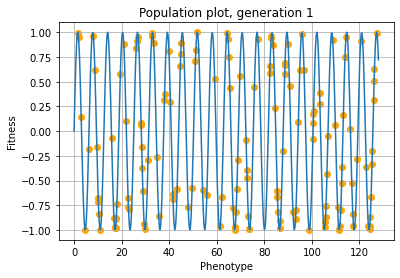

Average fitness of generation 1 is -0.12550698948411265 
| Fitness lower bound = -0.9996074904836875 | Fitness upper bound = 0.9989439815347072
Population size = 150


Max age: 2 | Min age: 1


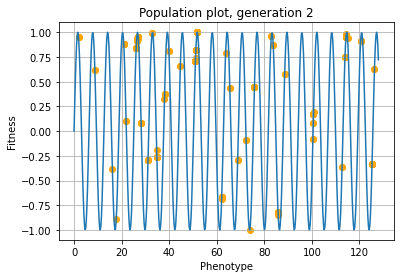

Average fitness of generation 2 is 0.4254662098559224 
| Fitness lower bound = -0.9993517379625831 | Fitness upper bound = 0.9989439926364372
Population size = 150


Max age: 3 | Min age: 1


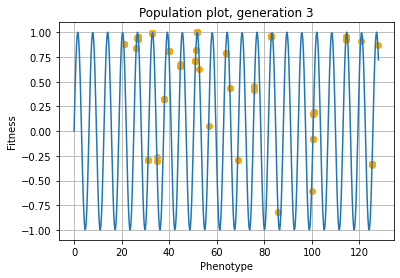

Average fitness of generation 3 is 0.5557803602031745 
| Fitness lower bound = -0.8201202495909731 | Fitness upper bound = 0.998944049638621
Population size = 150


Max age: 4 | Min age: 1


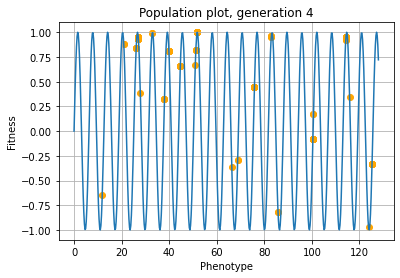

Average fitness of generation 4 is 0.6356484754640974 
| Fitness lower bound = -0.9737863507448655 | Fitness upper bound = 0.9990534786865042
Population size = 150


Max age: 5 | Min age: 1


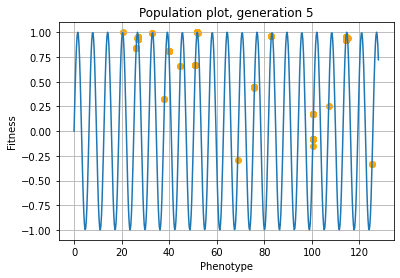

Average fitness of generation 5 is 0.7546955813546344 
| Fitness lower bound = -0.336990297341776 | Fitness upper bound = 0.999481628494232
Population size = 150


Max age: 5 | Min age: 1


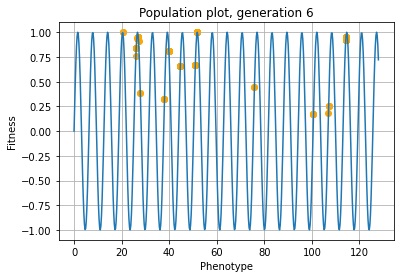

Average fitness of generation 6 is 0.8312605100673532 
| Fitness lower bound = 0.16815398105637236 | Fitness upper bound = 0.9995125916658625
Population size = 150


Max age: 4 | Min age: 1


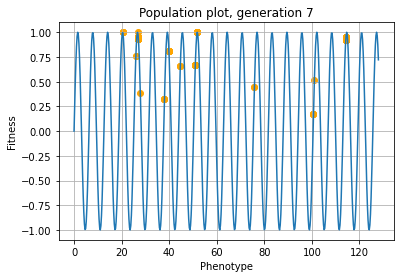

Average fitness of generation 7 is 0.8485279936673326 
| Fitness lower bound = 0.16815398105637236 | Fitness upper bound = 0.9999934624367846
Population size = 150


Max age: 5 | Min age: 1


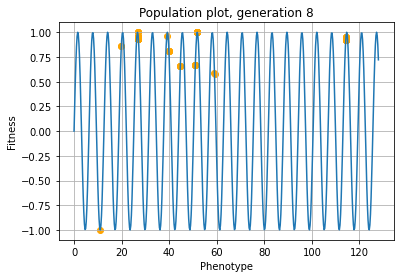

Average fitness of generation 8 is 0.9070681447981205 
| Fitness lower bound = -0.9967657958816628 | Fitness upper bound = 0.9999934624367846
Population size = 150


Max age: 6 | Min age: 1


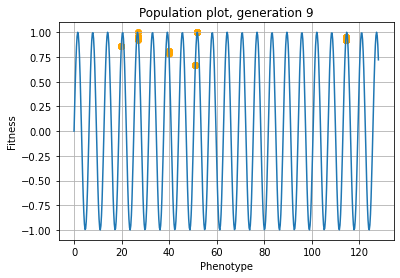

Average fitness of generation 9 is 0.9247755483456719 
| Fitness lower bound = 0.6726089613491766 | Fitness upper bound = 0.9999934710550353
Population size = 150


Max age: 6 | Min age: 1


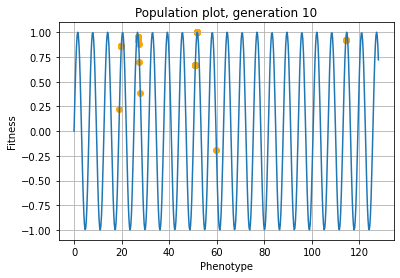

Average fitness of generation 10 is 0.9100363971637457 
| Fitness lower bound = -0.19080221872392045 | Fitness upper bound = 0.9989439881578261
Population size = 150




In [107]:
# Choose survivor selection method. Either 'age' or 'tournament'

population = sga(survivor_selection = 'age', use_dataset=False)

*f) This task is identical to e), however, we now add the constraint that the
solution must reside in the interval [5,10]. The constraint should not be
handled by scaling the real value of the bitstring into the new interval.
Throughout the generations plot the individuals, values and fitness values with
the sine wave.*

We are to handle a constraint. In the excersise we are taught how to utilize such constraints. 

*"Constraints can be handled indirectly by adding a penalty term to the fitness
function. The original fitness function f(x) is then transformed into f’(x) = f(x) +
P(d(x,F)), where d(x,F) is a distance metric of the infeasible point to the feasible
region F. The penalty function P is zero for feasible solutions and increases
proportionally with the distance to the feasible region."*

Max age: 1 | Min age: 1


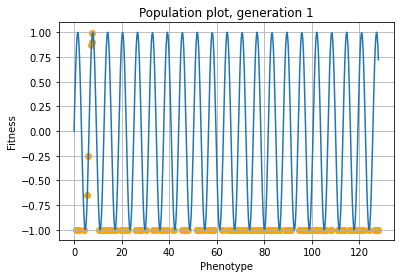

Average fitness of generation 1 is -0.954247374453788 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.9931054838556488
Population size = 150


Max age: 2 | Min age: 1


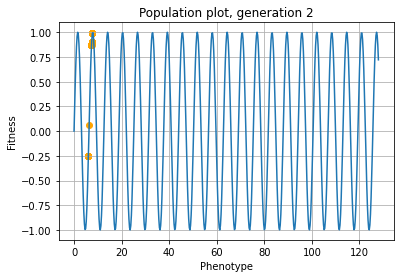

Average fitness of generation 2 is 0.5673334004778252 
| Fitness lower bound = -0.2524880121965498 | Fitness upper bound = 0.9931054839573337
Population size = 150


Max age: 3 | Min age: 1


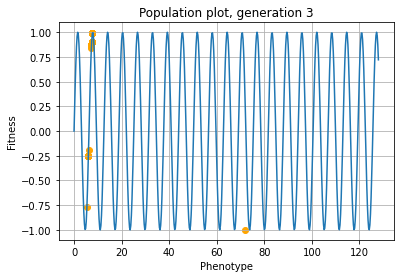

Average fitness of generation 3 is 0.7663949704792034 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.9933822083461608
Population size = 150


Max age: 4 | Min age: 1


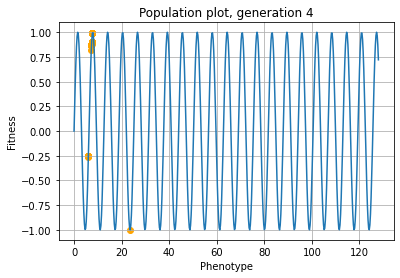

Average fitness of generation 4 is 0.8517451139485213 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.9944720843561767
Population size = 150


Max age: 5 | Min age: 1


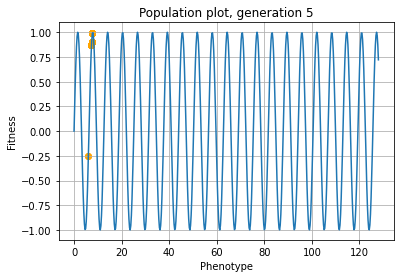

Average fitness of generation 5 is 0.9116337416147123 
| Fitness lower bound = -0.2504537115133033 | Fitness upper bound = 0.9942491924239834
Population size = 150


Max age: 6 | Min age: 1


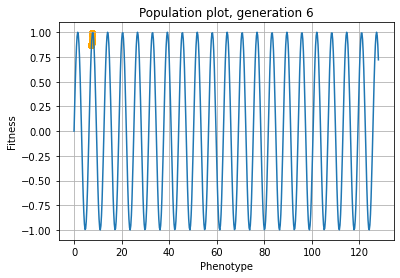

Average fitness of generation 6 is 0.9404057518851623 
| Fitness lower bound = 0.8707953153823524 | Fitness upper bound = 0.9941409608178007
Population size = 150


Max age: 5 | Min age: 1


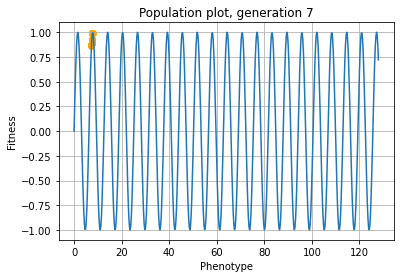

Average fitness of generation 7 is 0.9393826033936739 
| Fitness lower bound = 0.8658915844982644 | Fitness upper bound = 0.9942491924239834
Population size = 150


Max age: 5 | Min age: 1


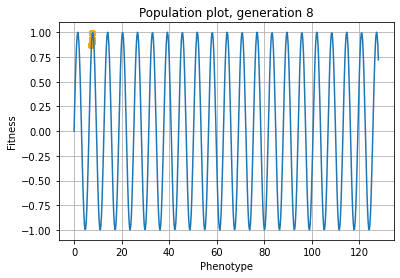

Average fitness of generation 8 is 0.9600217982539782 
| Fitness lower bound = 0.8659526414878942 | Fitness upper bound = 0.9942491924240966
Population size = 150


Max age: 5 | Min age: 1


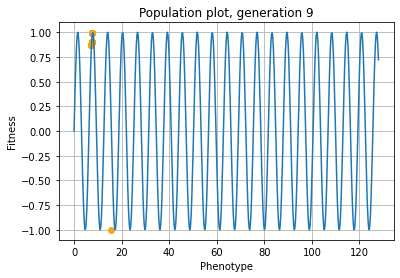

Average fitness of generation 9 is 0.9555500908368769 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.9943532993552344
Population size = 150


Max age: 6 | Min age: 1


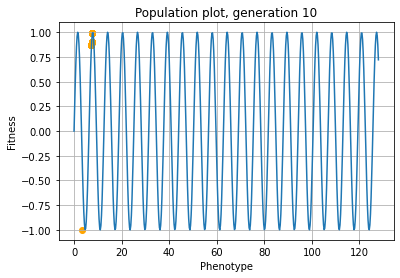

Average fitness of generation 10 is 0.947765089195705 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.9941673206909458
Population size = 150




In [109]:
enable_constraint = (True, [5, 10])

population = sga(survivor_selection = 'age', use_dataset=False)

## For the feature selection problem

*g) Run the genetic algorithm on the provided dataset. Show the results, and
compare them to the results of not using any feature selection (given by
running the linear regression with all features selected). The points given here
depend on the achieved quality of the result and team size.*

- *For a 2-person team RMSE less than 0.124.*

Updating the chromosonme_length to match the dataset. Must be 101, since there are 101 columns. The 102. column is the value column.

In [177]:
# Important that the chromosome length should be 101 (instead of 102)
chromosome_length = data.shape[1] - 1
enable_constraint = (False, [5, 10])
pop_size = 10
g_max = 100

### Running the genetic algorithm on the provideded dataset using feature selection

Notice that if the population size is very high, then one is likely to get one individual below the threshold in the random intialization of the population.

In [178]:
population = sga(survivor_selection = 'age', use_dataset=True, threshold=0.124)

Max age: 1 | Min age: 1
Average fitness of generation 1 is 0.1376934521385098 
| Fitness lower bound = 0.127154858238667 | Fitness upper bound = 0.15188670526773548
Population size = 10


Max age: 2 | Min age: 1
Average fitness of generation 2 is 0.13917271677996562 
| Fitness lower bound = 0.12909726811752448 | Fitness upper bound = 0.14844856793533373
Population size = 10


Max age: 3 | Min age: 1
Average fitness of generation 3 is 0.13741034315873382 
| Fitness lower bound = 0.12522675983448903 | Fitness upper bound = 0.15157035219611217
Population size = 10


Max age: 2 | Min age: 1
Average fitness of generation 4 is 0.1373675418849365 
| Fitness lower bound = 0.12522675983448903 | Fitness upper bound = 0.1496980716470086
Population size = 10


Max age: 2 | Min age: 1
Average fitness of generation 5 is 0.13661749417869698 
| Fitness lower bound = 0.12563390677651262 | Fitness upper bound = 0.1496980716470086
Population size = 10


Max age: 2 | Min age: 1
Average fitness of generati

### Running the genetic algorithm on the provideded dataset **without** using feature selection

In [112]:
regressor.get_fitness(data.values[:,:-1], data.values[:,-1])

0.13809854811064307

*h) Implement a new survivor selection function. This function should be using a
crowding technique as described in the section about crowding. Do exercise f)
and g) again with the new selection function, and compare the results to using
the simple genetic algorithm. Also show and compare how the entropies of
the different approaches (SGA and crowding) change through the generations
through a plot.*

- For a 2-person team: implement and demonstrate two crowding
approaches.

Here we have implemented two crowding methods. We have implemented **deterministic** and **probabilistic** replacement for crowding according to Mahfoud (as detailed in the lecture slides). Some of the details are also in the sga-algorithm below.

In [113]:
def mahfoud_crowding(c1, c2, p1, p2, use_dataset, replacement_method):
    if hamming_distance(p1.genotype, c1.genotype) + hamming_distance(p2.genotype, c2.genotype) \
    < hamming_distance(p1.genotype, c2.genotype) + hamming_distance(p2.genotype, c1.genotype):
        
        # p1 agains  c1
        person_a = replacement_method(p1, c1, use_dataset)
        # p2 against c2
        person_b = replacement_method(p2, c2, use_dataset)

        return person_a, person_b
    else:
        # p1 against c2
        person_a = replacement_method(p1, c2, use_dataset)
        # p2 against c1
        person_b = replacement_method(p2, c1, use_dataset)

        return person_a, person_b


def deterministic_crowding(parent, child, use_dataset):
    p_fitness, c_fitness = get_fitness(parent, child, use_dataset)
    if c_fitness > p_fitness:
        return child
    elif c_fitness < p_fitness:
        return parent
    else:
        # If the their fitnesses are the same, this picks either with a 50% likelihood. 
        return random.choices([child, parent], weights=[0.5, 0.5], k=1)[0]
    return 

def probablistic_crowding(parent, child, use_dataset):
    p_fitness, c_fitness = get_fitness(parent, child, use_dataset)
    # Probability that the child replaces the parent
    p = (c_fitness) / (c_fitness + p_fitness)

    return random.choices([child, parent], weights=[p, 1 - p], k=1)[0]

def get_fitness(parent, child, use_dataset):
    if use_dataset:
        return parent.rmse_fitness, child.rmse_fitness
    else:
        return parent.sin_fitness, child.sin_fitness


def hamming_distance(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("Strings must be of equal length")

    return sum(c1 != c2 for c1, c2 in zip(str1, str2))


### Creating a function to plot entropies

In [114]:
def plot_entropies(e1, e2):
    generations = [point[0] for point in e1]
    entropies = [point[1] for point in e1]
    plt.plot(generations, entropies, marker='o', label='Crowding')  

    generations = [point[0] for point in e2]
    entropies = [point[1] for point in e2]
    plt.plot(generations, entropies, marker='o', label='Simple Genetic Algorithm')  

    plt.xlabel('Generation')
    plt.ylabel('Entropy')
    plt.title('Entropy Over Generations')
    plt.grid(True) 
    plt.legend()

    plt.show()

### Now doing task f) 

- The goal is to compare our crowding methods with normal SGA. We will also present a plot on the entropy.


In [115]:
pop_size = 100
chromosome_length = 50
generation_number = 1
crossover_rate = 0.7
mutation_rate = 0.01
num_parents = int(np.floor(pop_size/2))
g_max = 75
enable_constraint = (True, [5, 10])

Max age: 1 | Min age: 1
Average fitness of generation 1 is -0.9529108234061795 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.9714603449396495
Population size = 100


Max age: 2 | Min age: 1
Average fitness of generation 2 is 0.6282462838132884 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.972566438629892
Population size = 100


Max age: 3 | Min age: 1
Average fitness of generation 3 is 0.6555583519465584 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.979359948287478
Population size = 100


Max age: 4 | Min age: 1
Average fitness of generation 4 is 0.7057413535120941 
| Fitness lower bound = -0.22376675695132875 | Fitness upper bound = 0.979359948287478
Population size = 100


Max age: 5 | Min age: 1
Average fitness of generation 5 is 0.8717263009759975 
| Fitness lower bound = -0.22376675550112535 | Fitness upper bound = 0.9881056490170601
Population size = 100


Max age: 6 | Min age: 1
Average fitness of generation 6 is 0.9644425026340437 
| Fitness lower 

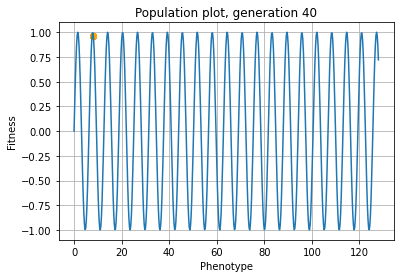

Average fitness of generation 40 is 0.9612297649852599 
| Fitness lower bound = 0.9611869534924968 | Fitness upper bound = 0.9613587135918253
Population size = 100


Max age: 8 | Min age: 1
Average fitness of generation 41 is 0.9612327714250748 
| Fitness lower bound = 0.9611869534924968 | Fitness upper bound = 0.9613586397511518
Population size = 100


Max age: 9 | Min age: 1
Average fitness of generation 42 is 0.96122649203687 
| Fitness lower bound = 0.9611869534924968 | Fitness upper bound = 0.9613572695792316
Population size = 100


Max age: 10 | Min age: 1
Average fitness of generation 43 is 0.9615061308048679 
| Fitness lower bound = 0.9612206252714968 | Fitness upper bound = 0.9881057080218021
Population size = 100


Max age: 11 | Min age: 1
Average fitness of generation 44 is 0.9612267086006746 
| Fitness lower bound = 0.9612206252714968 | Fitness upper bound = 0.9613572695792316
Population size = 100


Max age: 7 | Min age: 1
Average fitness of generation 45 is 0.961229403985

In [116]:
population_sga, entropy_points_sga = sga(survivor_selection='age', use_dataset=False,
                                         enable_entropy=True, plot_silencer=(True, 40))

Max age: 1 | Min age: 1
Average fitness of generation 1 is -0.9781870309480215 
| Fitness lower bound = -1.0 | Fitness upper bound = 0.9796277017078827
Population size = 100


Max age: 2 | Min age: 1
Average fitness of generation 2 is 0.9252277019329621 
| Fitness lower bound = -0.8396946752829884 | Fitness upper bound = 0.9854240799406879
Population size = 100


Max age: 3 | Min age: 1
Average fitness of generation 3 is 0.9612545224488065 
| Fitness lower bound = -0.8354264463060035 | Fitness upper bound = 0.9854240799407075
Population size = 100


Max age: 4 | Min age: 1
Average fitness of generation 4 is 0.980809382226999 
| Fitness lower bound = 0.9796277017078827 | Fitness upper bound = 0.9854240805747283
Population size = 100


Max age: 5 | Min age: 1
Average fitness of generation 5 is 0.9812790415632441 
| Fitness lower bound = 0.9796277017078827 | Fitness upper bound = 0.9879617424565477
Population size = 100


Max age: 6 | Min age: 1
Average fitness of generation 6 is 0.982086

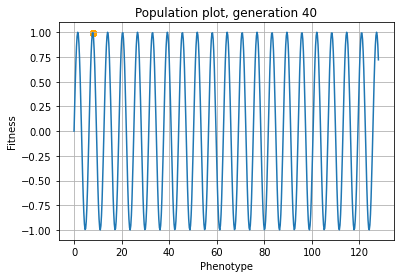

Average fitness of generation 40 is 0.9892221410795239 
| Fitness lower bound = 0.9887602440221543 | Fitness upper bound = 0.9893578972445509
Population size = 100


Max age: 12 | Min age: 1
Average fitness of generation 41 is 0.9892228154392445 
| Fitness lower bound = 0.9887602440221543 | Fitness upper bound = 0.9893567849885299
Population size = 100


Max age: 13 | Min age: 1
Average fitness of generation 42 is 0.9892020309642355 
| Fitness lower bound = 0.9887602440221543 | Fitness upper bound = 0.9893577563480973
Population size = 100


Max age: 12 | Min age: 1
Average fitness of generation 43 is 0.9892765081638635 
| Fitness lower bound = 0.9887602440221543 | Fitness upper bound = 0.9893568543706961
Population size = 100


Max age: 13 | Min age: 1
Average fitness of generation 44 is 0.9892986534212972 
| Fitness lower bound = 0.9887602440221543 | Fitness upper bound = 0.9893568543719202
Population size = 100


Max age: 9 | Min age: 1
Average fitness of generation 45 is 0.98931293

In [117]:
population_crowding, entropy_points_crowding = sga(survivor_selection=None, use_dataset=False, 
                          crowding=(mahfoud_crowding, deterministic_crowding), enable_entropy=True, plot_silencer=(True, 40))

### Comparing entropies

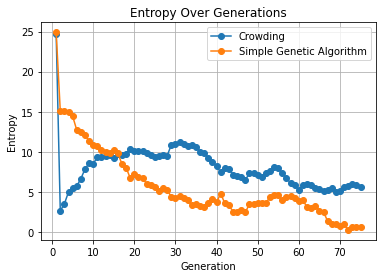

In [118]:
plot_entropies(entropy_points_crowding, entropy_points_sga)

### Comparing Results

Its seems that the implementation with crowding yields a higher average fitness. It also clear from the entropy plot that the crowding GA mantains diversity better than the simple SGA with increasing genenerations. This finding is consistent with the description for project 1A.

### Redoing doing task g)

In [169]:
chromosome_length = data.shape[1] - 1
enable_constraint = (False, [5, 10])
pop_size = 10
g_max = 100

In [170]:
population_crowding, entropy_points_crowding  = sga(survivor_selection = None, use_dataset=True,
                                                     crowding=(mahfoud_crowding, probablistic_crowding), enable_entropy=True,
                                                     threshold=0.124)

Max age: 1 | Min age: 1
Average fitness of generation 1 is 0.13760123433771093 
| Fitness lower bound = 0.1282994283503735 | Fitness upper bound = 0.14603167490213703
Population size = 10


Max age: 2 | Min age: 1
Average fitness of generation 2 is 0.14123628295679364 
| Fitness lower bound = 0.13435351374292973 | Fitness upper bound = 0.14734487832022064
Population size = 10


Max age: 3 | Min age: 1
Average fitness of generation 3 is 0.13985348273412196 
| Fitness lower bound = 0.13435351374292973 | Fitness upper bound = 0.15062133298433578
Population size = 10


Max age: 3 | Min age: 1
Average fitness of generation 4 is 0.13948167037059891 
| Fitness lower bound = 0.12919470173683908 | Fitness upper bound = 0.15453818684525295
Population size = 10


Max age: 3 | Min age: 1
Average fitness of generation 5 is 0.1435746926775955 
| Fitness lower bound = 0.132649453382009 | Fitness upper bound = 0.15792111639370376
Population size = 10


Max age: 4 | Min age: 1
Average fitness of genera

In [171]:
population_sga, entropy_points_sga = sga(survivor_selection = 'age', use_dataset=True, enable_entropy=True, threshold=0.124)

Max age: 1 | Min age: 1
Average fitness of generation 1 is 0.1385695841299498 
| Fitness lower bound = 0.13246425293416692 | Fitness upper bound = 0.14663633185997046
Population size = 10


Max age: 2 | Min age: 1
Average fitness of generation 2 is 0.1401719563014342 
| Fitness lower bound = 0.12925250787246953 | Fitness upper bound = 0.14729185067551584
Population size = 10


Max age: 3 | Min age: 1
Average fitness of generation 3 is 0.14152575727118535 
| Fitness lower bound = 0.13226569476882227 | Fitness upper bound = 0.14729185067551584
Population size = 10


Max age: 4 | Min age: 1
Average fitness of generation 4 is 0.13972730103760272 
| Fitness lower bound = 0.13226569476882227 | Fitness upper bound = 0.14663633185997046
Population size = 10


Max age: 2 | Min age: 1
Average fitness of generation 5 is 0.13742108210231885 
| Fitness lower bound = 0.12477140012793043 | Fitness upper bound = 0.14794891590417267
Population size = 10


Max age: 3 | Min age: 1
Average fitness of gene

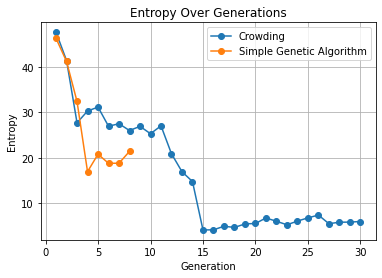

In [172]:
plot_entropies(entropy_points_crowding, entropy_points_sga)

### Observations and analysis

Note that without any feature selection we get a fitness usually a little higher than 0.124. A common RMSE is 0.14 give or take. 

Here we try to reach a RMSE of less than 0.124. This done by running a genetic algorithm with and without crowding. At the end we plot the entropies. Notice that when the population size is very high it is likely that one individual will have a really low rmse. For the purpose of of utilizing the algorithm more, we have chosen a population size of 10. Notice it is still possible for the algorithm hit it right at the initialzation.

Once again we can see that crowding implementation maintains more diversity than the SGA. This happens in both cases, f) and g).